In [1]:
import torch
from torch import nn
import pathlib
from torch.utils.data import DataLoader
from torchvision import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transformtrain = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])
transformtest = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

In [4]:
trainds = datasets.ImageFolder('../input/seg_train/seg_train', transform=transformtrain)
testds = datasets.ImageFolder('../input/seg_test/seg_test', transform=transformtest)

In [5]:
trainloader = DataLoader(trainds, batch_size=256, shuffle=True)
testloader = DataLoader(testds, batch_size=64, shuffle=False)

In [6]:
root = pathlib.Path('../input/seg_train/seg_train')
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [7]:
model = models.vgg19(pretrained=True).to(device)
for param in model.features.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /tmp/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:12<00:00, 45706131.87it/s]


In [8]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [9]:
model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.00001)

In [10]:
trainlosses = []
testlosses = []
for e in range(50):
    trainloss = 0
    traintotal = 0
    trainsuccessful = 0
    for traininput, trainlabel in trainloader:
        traininputs, trainlabels = traininput.to(device), trainlabel.to(device)
        optimizer.zero_grad()
        trainpredictions = model(traininputs)
        _, trainpredict = torch.max(trainpredictions.data, 1)
        loss = criterion(trainpredictions, trainlabels)
        loss.backward()
        optimizer.step()
        trainloss += loss.item()
        traintotal += trainlabels.size(0)
        trainsuccessful += (trainpredict == trainlabels).sum().item()
    else:
        testloss = 0
        testtotal = 0
        testsuccessful = 0
        with torch.no_grad():
            for testinput, testlabel in testloader:
                testinputs, testlabels = testinput.to(device), testlabel.to(device)
                testpredictions = model(testinputs)
                _, testpredict = torch.max(testpredictions.data, 1)
                tloss = criterion(testpredictions, testlabels)
                testloss += tloss.item()
                testtotal += testlabels.size(0)
                testsuccessful += (testpredict == testlabels).sum().item()
        trainlosses.append(trainloss/len(trainloader))
        testlosses.append(testloss/len(testloader))
        print('Train Accuracy %{:.2f}'.format(100*trainsuccessful/traintotal))
        print('Test Accuracy %{:.2f}'.format(100*testsuccessful/testtotal))


Train Accuracy %64.59
Test Accuracy %84.10
Train Accuracy %86.08
Test Accuracy %86.43
Train Accuracy %88.35
Test Accuracy %89.03
Train Accuracy %89.41
Test Accuracy %89.77
Train Accuracy %90.07
Test Accuracy %90.17
Train Accuracy %90.79
Test Accuracy %89.90
Train Accuracy %91.38
Test Accuracy %90.50
Train Accuracy %91.77
Test Accuracy %90.30
Train Accuracy %91.96
Test Accuracy %91.20
Train Accuracy %92.52
Test Accuracy %90.60
Train Accuracy %92.80
Test Accuracy %91.27
Train Accuracy %93.12
Test Accuracy %91.33
Train Accuracy %93.22
Test Accuracy %91.43
Train Accuracy %93.52
Test Accuracy %91.33
Train Accuracy %94.13
Test Accuracy %90.90
Train Accuracy %94.00
Test Accuracy %91.43
Train Accuracy %94.35
Test Accuracy %91.40
Train Accuracy %94.37
Test Accuracy %91.43
Train Accuracy %94.96
Test Accuracy %91.50
Train Accuracy %94.93
Test Accuracy %90.80
Train Accuracy %95.05
Test Accuracy %91.50
Train Accuracy %95.17
Test Accuracy %91.47
Train Accuracy %95.66
Test Accuracy %91.30
Train Accur

In [11]:
import matplotlib.pyplot as plt

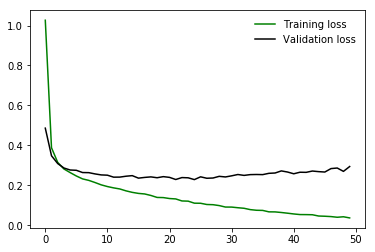

In [12]:
plt.plot(trainlosses, label='Training loss', color='green')
plt.plot(testlosses, label='Validation loss', color='black')
plt.legend(frameon=False)
plt.show()

Seems there is overfitting. You could use L2 regularization or dropout to get better test accuracy if you wish to give it a try.

In [13]:
!ls ../input/seg_pred/seg_pred/3966.jpg

../input/seg_pred/seg_pred/3966.jpg


__Let's predict__

In [14]:
from PIL import Image
import numpy as np

In [15]:
img = Image.open('../input/seg_pred/seg_pred/3966.jpg')

In [16]:
nimg = np.array(img)

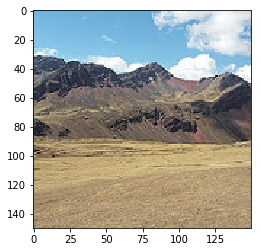

In [17]:
plt.imshow(nimg)

In [18]:
pimg = transformtest(img).unsqueeze(0).to(device)

In [19]:
pimg.shape

torch.Size([1, 3, 150, 150])

In [20]:
prediction = model(pimg)

In [21]:
_, tpredict = torch.max(prediction.data, 1)

In [22]:
classes[tpredict[0].item()]

'mountain'

It is amazing, isn't it?